# 🤟 Sign Language Classifier

A CNN-based model to classify hand sign images into alphabet labels.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Dataset
import os

# Set seed and device
SEED = 42
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1.Load and Explore data

In [3]:
DATA_DIR = 'SignLanguage_kaggle'

# Load datasets
annotated_dataset = torch.load(os.path.join(DATA_DIR, 'old_annotated.pth'), weights_only=False)
manual_labels_dataset = torch.load(os.path.join(DATA_DIR, 'todo_example.pth'), weights_only=False)
unlabeled_dataset = torch.load(os.path.join(DATA_DIR, 'todo.pth'), weights_only=False)

# Combine labeled datasets into one training dataset for training
combined_labeled_dataset = annotated_dataset + manual_labels_dataset

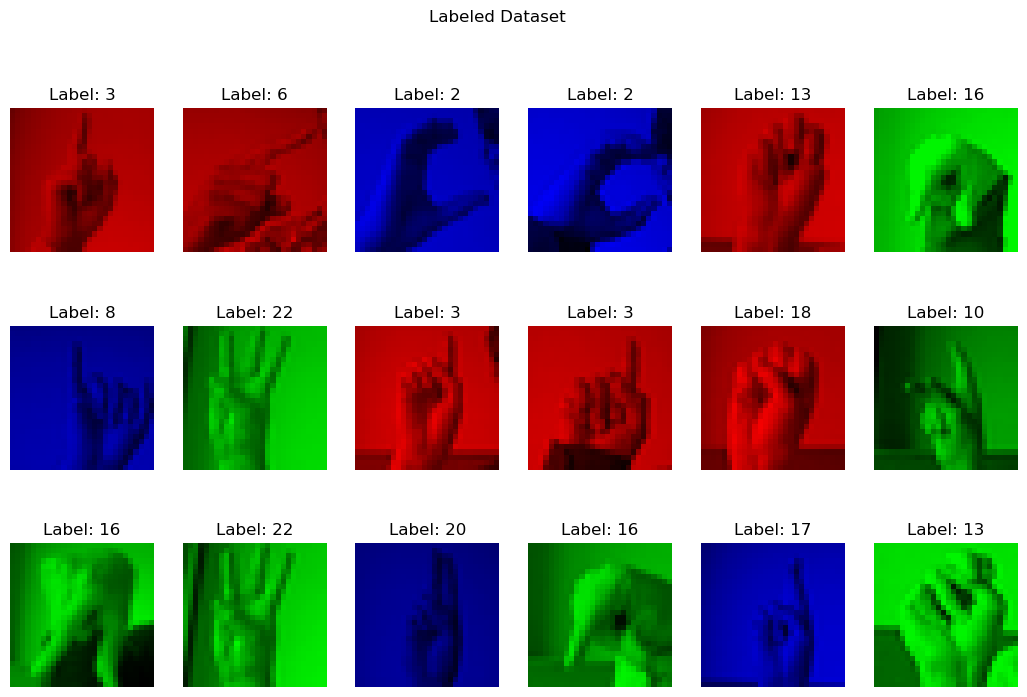

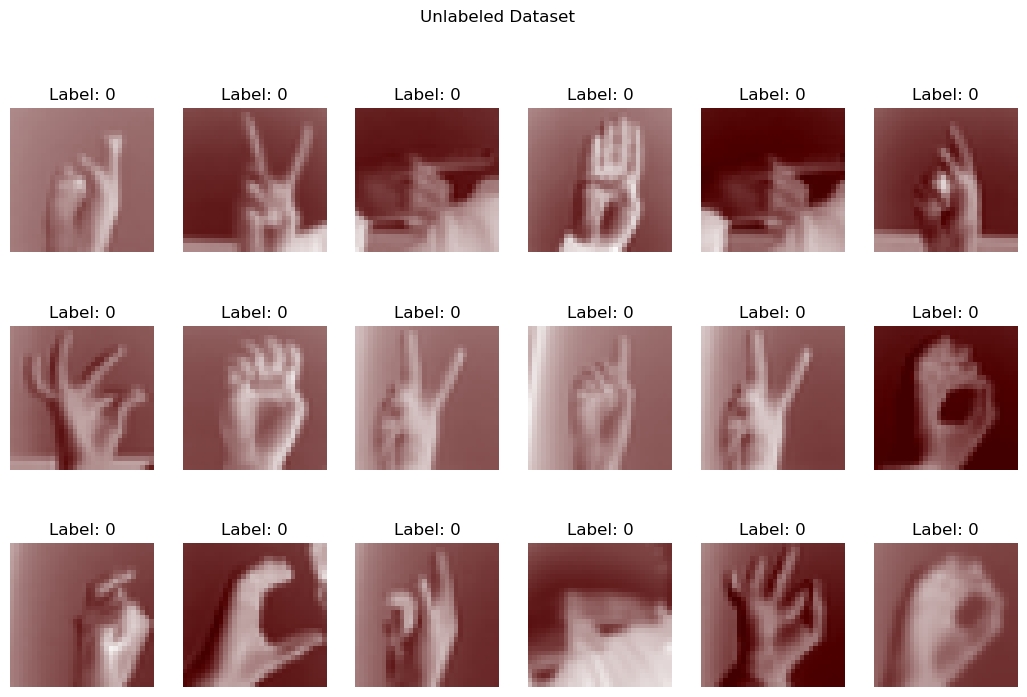

In [4]:
def visualize_samples(dataset, title="Dataset Samples"):
    fig = plt.figure(figsize=(13, 8))
    columns, rows = 6, 3
    for i in range(columns * rows):
        image, label = dataset[i]
        ax = fig.add_subplot(rows, columns, i + 1)
        ax.set_title(f"Label: {label.item()}")
        ax.axis('off')
        image_np = image.permute(1, 2, 0).numpy()
        ax.imshow(image_np)
    plt.suptitle(title)
    plt.show()

# Visualize sample images
visualize_samples(combined_labeled_dataset, title="Labeled Dataset")
visualize_samples(unlabeled_dataset, title="Unlabeled Dataset")

## 2.Preprocess data

In [ ]:
# Define training data augmentation
train_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomAdjustSharpness(0.5),
    transforms.RandomInvert(),
    transforms.ColorJitter(brightness=0.5, hue=0.5),
    transforms.RandomHorizontalFlip(),
    transforms.Grayscale()
])

# Define test/validation transforms (no augmentation)
test_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale()
])

# Custom Dataset Wrapper to apply transforms
class SignLanguageDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Create datasets for training and inference
full_dataset = SignLanguageDataset(combined_labeled_dataset, transform=train_transforms)
inference_dataset = SignLanguageDataset(unlabeled_dataset, transform=test_transforms)

In [6]:
# 80% train, 20% validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32)
inference_loader = DataLoader(inference_dataset, batch_size=32)

## 3.Build Model

In [7]:
class SignLanguageCNN(nn.Module):
    def __init__(self):
        super(SignLanguageCNN, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 25)  # 25 possible labels
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Instantiate model
model = SignLanguageCNN().to(device)

## 4.Loss Function and Optimization method

In [ ]:
import numpy as np
from tqdm import tqdm

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler: reduces LR when validation loss plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)


## 5.Train model


In [ ]:
# Training loop settings
num_epochs = 20
patience = 5  # for early stopping
best_val_loss = float('inf')
patience_counter = 0

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation loop
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

    scheduler.step(avg_val_loss)

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break


Epoch 1/20: 100%|█████████████████████████████| 689/689 [00:26<00:00, 26.32it/s]


Epoch 1: Train Loss = 3.1863, Val Loss = 3.1639


Epoch 2/20: 100%|█████████████████████████████| 689/689 [00:26<00:00, 26.27it/s]


Epoch 2: Train Loss = 2.6918, Val Loss = 1.9958


Epoch 3/20: 100%|█████████████████████████████| 689/689 [00:26<00:00, 25.92it/s]


Epoch 3: Train Loss = 1.8916, Val Loss = 1.4071


Epoch 4/20: 100%|█████████████████████████████| 689/689 [00:26<00:00, 26.25it/s]


Epoch 4: Train Loss = 1.5047, Val Loss = 1.0361


Epoch 5/20: 100%|█████████████████████████████| 689/689 [00:27<00:00, 25.21it/s]


Epoch 5: Train Loss = 1.2357, Val Loss = 0.7995


Epoch 6/20: 100%|█████████████████████████████| 689/689 [00:27<00:00, 25.23it/s]


Epoch 6: Train Loss = 1.0484, Val Loss = 0.6985


Epoch 7/20: 100%|█████████████████████████████| 689/689 [00:26<00:00, 26.07it/s]


Epoch 7: Train Loss = 0.9241, Val Loss = 0.5485


Epoch 8/20: 100%|█████████████████████████████| 689/689 [00:27<00:00, 25.33it/s]


Epoch 8: Train Loss = 0.8273, Val Loss = 0.4858


Epoch 9/20: 100%|█████████████████████████████| 689/689 [00:26<00:00, 26.49it/s]


Epoch 9: Train Loss = 0.7462, Val Loss = 0.4068


Epoch 10/20: 100%|████████████████████████████| 689/689 [00:26<00:00, 25.81it/s]


Epoch 10: Train Loss = 0.6769, Val Loss = 0.3275


Epoch 11/20: 100%|████████████████████████████| 689/689 [00:25<00:00, 26.65it/s]


Epoch 11: Train Loss = 0.6372, Val Loss = 0.3329


Epoch 12/20: 100%|████████████████████████████| 689/689 [00:26<00:00, 26.30it/s]


Epoch 12: Train Loss = 0.5839, Val Loss = 0.2579


Epoch 13/20: 100%|████████████████████████████| 689/689 [00:25<00:00, 26.64it/s]


Epoch 13: Train Loss = 0.5374, Val Loss = 0.2564


Epoch 14/20: 100%|████████████████████████████| 689/689 [00:25<00:00, 26.60it/s]


Epoch 14: Train Loss = 0.4960, Val Loss = 0.2079


Epoch 15/20: 100%|████████████████████████████| 689/689 [00:26<00:00, 26.42it/s]


Epoch 15: Train Loss = 0.4743, Val Loss = 0.2125


Epoch 16/20: 100%|████████████████████████████| 689/689 [00:25<00:00, 26.77it/s]


Epoch 16: Train Loss = 0.4447, Val Loss = 0.1691


Epoch 17/20: 100%|████████████████████████████| 689/689 [00:25<00:00, 26.76it/s]


Epoch 17: Train Loss = 0.4152, Val Loss = 0.1857


Epoch 18/20: 100%|████████████████████████████| 689/689 [00:26<00:00, 25.90it/s]


Epoch 18: Train Loss = 0.4129, Val Loss = 0.1507


Epoch 19/20: 100%|████████████████████████████| 689/689 [00:26<00:00, 26.42it/s]


Epoch 19: Train Loss = 0.3890, Val Loss = 0.1470


Epoch 20/20: 100%|████████████████████████████| 689/689 [00:26<00:00, 25.90it/s]


Epoch 20: Train Loss = 0.3713, Val Loss = 0.1182


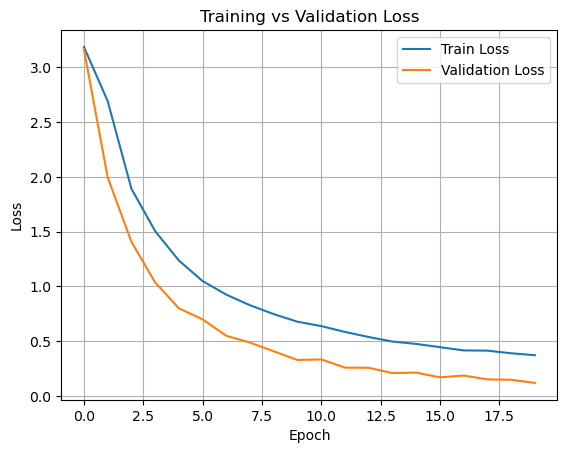

In [9]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid()
plt.show()

## 6.Evaluate Model(make prediction)

In [10]:
# Load best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

predictions = []
with torch.no_grad():
    for images, _ in inference_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())


submission_df = pd.DataFrame({
    "ID": list(range(len(predictions))),
    "Label": predictions
})

submission_filename = f"submission_{np.random.randint(10000)}.csv"
submission_df.to_csv(submission_filename, index=False)
print(f"Submission saved as {submission_filename}")

Submission saved as submission_5226.csv
